<a href="https://colab.research.google.com/github/pletalk/EMPV-RPI-AutoDriving/blob/master/06-EMPV1-AutoLaneFollow-Colab/01-EMPV1_AutonomousDriving_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMPV1 : 라즈베리파이기반 딥러닝 자율주행(Deep Learning Driving)

@2020-08-01/@Ignitespark

Donkeycar의 제어모듈에 DeepPiCar의 openCV기반주행데이타를 활용한 NVIDIA 딥러닝 모델 학습하기

* 문서이력
    * 2020-08-01 수행점검 및 코드변경(data.zip 업로드, EMPV1코드연동)
    * 2020-07-15 테스트결과, 각도를 이미지 데이타와 함께 구하고, 이를 학습에 활용 (실제 출력에서는 각도값을 steering값으로 변환)
    * 2020-07-14 기존의 DeepPiCar의 주행데이타 활용 Colab 상에 EMPV1의 openCV 주행 데이타를 업로드하고 모델 학습
    * 2020-06-22 데이타변형없이 주행데이타만으로 학습
    * 2020-06-14 재검증(OK)
    * 2020-05-24 코드추가하기(이미지로딩, 추가, 학습등)
    * 2020-05-23 처음작성

* [참고자료]
    * [참조 소스코드(DeepPiCar)](https://github.com/dctian/DeepPiCar/blob/master/models/lane_navigation/code/end_to_end_lane_navigation.ipynb)
    * [DeepPiCar — Part 5: Autonomous Lane Navigation via Deep Learning](https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110)

<img src="https://miro.medium.com/max/1374/1*p8JiHcvH-wpSxcCzz2r1Sw.jpeg"/>

## [1] 데이타 로딩 (EMPV! 주행 데이타 로딩)
* data.zip파일을 /content 에 업로드 하기

In [1]:
%cd /content
%pwd

/content


'/content'

#### 1> data.zip 파일 업로드하기

In [3]:
import os
from google.colab import files

uploaded = files.upload()

Saving data.zip to data.zip


#### 2> data 폴더생성하기

In [5]:
import shutil

DATA_FOLDER = "/content/data"
if(os.path.exists(DATA_FOLDER) == True):  
    shutil.rmtree(DATA_FOLDER)
os.makedirs(DATA_FOLDER)

In [7]:
%ls -1

data/
data.zip
sample_data/


#### 3> data.zip 압축풀기

In [11]:
! unzip ./data.zip -d /content

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/__MACOSX/data/tub_5_20-07-14/._record_193.json  
  inflating: /content/data/tub_5_20-07-14/23_cam-image_array_.jpg  
  inflating: /content/__MACOSX/data/tub_5_20-07-14/._23_cam-image_array_.jpg  
  inflating: /content/data/tub_5_20-07-14/record_68.json  
  inflating: /content/__MACOSX/data/tub_5_20-07-14/._record_68.json  
  inflating: /content/data/tub_5_20-07-14/record_87.json  
  inflating: /content/__MACOSX/data/tub_5_20-07-14/._record_87.json  
  inflating: /content/data/tub_5_20-07-14/record_202.json  
  inflating: /content/__MACOSX/data/tub_5_20-07-14/._record_202.json  
  inflating: /content/data/tub_5_20-07-14/236_cam-image_array_.jpg  
  inflating: /content/__MACOSX/data/tub_5_20-07-14/._236_cam-image_array_.jpg  
  inflating: /content/data/tub_5_20-07-14/record_150.json  
  inflating: /content/__MACOSX/data/tub_5_20-07-14/._record_150.json  
  inflating: /content/data/tub_5_20-07-14/record_5.json  
  inflating: /conte

#### 4> data.zip파일 삭제하기

In [12]:
# MacOSX에서 압축하는 경우, 임시폴더가 생성되어 이를 삭제
MACOSX_DATA_FOLDER = "/content/__MACOSX"
if(os.path.exists(MACOSX_DATA_FOLDER) == True):  
    shutil.rmtree(MACOSX_DATA_FOLDER)

In [13]:
%rm -f data.zip

## [2] 라이브러리 로딩하기

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import logging
import math

import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
from imgaug import augmenters as img_aug
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

Using TensorFlow backend.


tf.__version__: 2.2.0
keras.__version__: 2.3.1


## [3] data 디렉토리 아래의 tub 디렉토리들의 전체 이미지 목록을 담은 csv생성하기
* 학습을 위한 데이타세트 구성하기
* 파이썬 프로그램을 업로드하고 수행하기 (tub2list_by_data.py)

In [15]:
%pwd

'/content'

#### 1> tub를 묶기 위한 코드 다운로드하기

In [16]:
# MacOSX에서 압축하는 경우, 임시폴더가 생성되어 이를 삭제
CODE_FOLDER = "/content/TUB2LIST"
if(os.path.exists(CODE_FOLDER) == True):  
    shutil.rmtree(CODE_FOLDER)
os.makedirs(CODE_FOLDER)

In [17]:
%cd /content/TUB2LIST

/content/TUB2LIST


In [26]:
GIT_HOME_URL = 'https://raw.githubusercontent.com/pletalk/EMPV-RPI-AutoDriving'

tub2index_path = f'{GIT_HOME_URL}/master/21-EMPV1-DPCAR/utils/tub2index/tub2index.py'
tub2list_by_data_path = f'{GIT_HOME_URL}/master/21-EMPV1-DPCAR/utils/tub2index/tub2list_by_data.py'

if(os.path.exists('tub2index.py') == True):  
    os.remove('tub2index.py')

if(os.path.exists('tub2list_by_data.py') == True):  
    os.remove('tub2list_by_data.py')


!wget {tub2index_path}
!wget {tub2list_by_data_path}

--2020-08-02 03:03:22--  https://raw.githubusercontent.com/pletalk/EMPV-RPI-AutoDriving/master/21-EMPV1-DPCAR/utils/tub2index/tub2index.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3821 (3.7K) [text/plain]
Saving to: ‘tub2index.py’

tub2index.py        100%[===================>]   3.73K  --.-KB/s    in 0s      

2020-08-02 03:03:22 (45.9 MB/s) - ‘tub2index.py’ saved [3821/3821]

--2020-08-02 03:03:23--  https://raw.githubusercontent.com/pletalk/EMPV-RPI-AutoDriving/master/21-EMPV1-DPCAR/utils/tub2index/tub2list_by_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, 

#### 2> data/tub_ 디렉토리들의 이미지와 json파일들을 하나로 병합하기

In [32]:
TUB2LIST_DIR='/content/TUB2LIST'
DATA_DIR= '/content/data'

TUB2LIST_BY_DATA_PATH = f'{TUB2LIST_DIR}/tub2list_by_data.py'
TUB2CSV_PATH = f'{TUB2LIST_DIR}/tub2list_by_data.csv'

In [33]:
TUB2LIST_BY_DATA_PATH

'/content/TUB2LIST/tub2list_by_data.py'

In [29]:
TUB2CSV_PATH

'/content/TUB2LIST/tub2list_by_data.csv'

In [34]:
!python {TUB2LIST_BY_DATA_PATH} --ddir {DATA_DIR} --o {TUB2CSV_PATH}

Namespace(ddir='/content/data', o='/content/TUB2LIST/tub2list_by_data.csv')
['tub_5_20-07-14', 'tub_12_20-07-14', 'tub_4_20-07-14', 'tub_6_20-07-14', 'tub_11_20-07-14', 'tub_3_20-07-14', 'tub_10_20-07-14', 'tub_7_20-07-14', 'tub_2_20-07-14', 'tub_1_20-07-14']
seqno-> 0 ,tub_full_path-> /content/data/tub_5_20-07-14
tub_target_dir=> /content/data/tub_5_20-07-14
249
>>> 해당tubdir에는 249개의 jpg파일이 있습니다
/content/data/tub_5_20-07-14/record_1.json
/content/data/tub_5_20-07-14/record_2.json
/content/data/tub_5_20-07-14/record_3.json
/content/data/tub_5_20-07-14/record_4.json
/content/data/tub_5_20-07-14/record_5.json
/content/data/tub_5_20-07-14/record_6.json
/content/data/tub_5_20-07-14/record_7.json
/content/data/tub_5_20-07-14/record_8.json
/content/data/tub_5_20-07-14/record_9.json
/content/data/tub_5_20-07-14/record_10.json
/content/data/tub_5_20-07-14/record_11.json
/content/data/tub_5_20-07-14/record_12.json
/content/data/tub_5_20-07-14/record_13.json
/content/data/tub_5_20-07-14/record_14

## [4] OpenCV기반 주행선탐지를 위한 이미지 목록 가져오기
    * directory에 주행을 캡쳐한 이미지들이 있음
    * 로딩을 위한 코드 작성

### 1> 이미지, 주행정보 데이타를 저장한 csv 파일 읽기

In [35]:
raw_df = pd.read_csv(TUB2CSV_PATH)

In [36]:
raw_df

,cam/image_array,user/angle,user/throttle,user/mode,milliseconds
0,tub_5_20-07-14/1_cam-image_array_.jpg,0.0000,0.1300,user,183
1,tub_5_20-07-14/2_cam-image_array_.jpg,0.0250,0.1300,user,189
2,tub_5_20-07-14/3_cam-image_array_.jpg,0.0250,0.1300,user,238
3,tub_5_20-07-14/4_cam-image_array_.jpg,0.0250,0.1300,user,290
4,tub_5_20-07-14/5_cam-image_array_.jpg,0.0000,0.1300,user,338
...,...,...,...,...,...
2160,tub_1_20-07-14/94_cam-image_array_.jpg,-0.6000,0.1200,user,4952
2161,tub_1_20-07-14/95_cam-image_array_.jpg,-0.5250,0.1200,user,5003
2162,tub_1_20-07-14/96_cam-image_array_.jpg,-0.5250,0.1200,user,5079
2163,tub_1_20-07-14/97_cam-image_array_.jpg,-0.4000,0.1200,user,5113


### 2> 불필요한 정보 제거하기 (3가지 정보 삭제)
* OpenCV기반의 주행에서는 throttle가 일정함으로 해당 정보는 불필요
* miliseconds 불필요
* user/mode 불필요

In [37]:
list_df = raw_df.drop(['user/mode','milliseconds','user/throttle'],axis=1)
list_df

,cam/image_array,user/angle
0,tub_5_20-07-14/1_cam-image_array_.jpg,0.0000
1,tub_5_20-07-14/2_cam-image_array_.jpg,0.0250
2,tub_5_20-07-14/3_cam-image_array_.jpg,0.0250
3,tub_5_20-07-14/4_cam-image_array_.jpg,0.0250
4,tub_5_20-07-14/5_cam-image_array_.jpg,0.0000
...,...,...
2160,tub_1_20-07-14/94_cam-image_array_.jpg,-0.6000
2161,tub_1_20-07-14/95_cam-image_array_.jpg,-0.5250
2162,tub_1_20-07-14/96_cam-image_array_.jpg,-0.5250
2163,tub_1_20-07-14/97_cam-image_array_.jpg,-0.4000


## [5] 학습데이타와 테스트 데이타 나누기

### 0> DataFrame에서 독립변수와 응답변수 분리하기

In [38]:
steering_angles = np.ravel(list_df['user/angle'])
image_paths = np.ravel(list_df['cam/image_array'])


steering_angles_2 = steering_angles * 40 + 90

In [39]:
steering_angles

array([0.0000, 0.0250, 0.0250, ..., -0.5250, -0.4000, -0.4000])

In [40]:
steering_angles_2

array([90.0000, 91.0000, 91.0000, ..., 69.0000, 74.0000, 74.0000])

### 1> train_test_split()를 활용하여 나누기 (비율기반)

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles_2, test_size=0.25)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 1623
Validation data: 542


In [42]:
X_train

array(['tub_12_20-07-14/131_cam-image_array_.jpg',
       'tub_12_20-07-14/194_cam-image_array_.jpg',
       'tub_6_20-07-14/98_cam-image_array_.jpg', ...,
       'tub_5_20-07-14/105_cam-image_array_.jpg',
       'tub_12_20-07-14/209_cam-image_array_.jpg',
       'tub_12_20-07-14/93_cam-image_array_.jpg'], dtype=object)

In [43]:
X_train.shape, y_train.shape

((1623,), (1623,))

Text(0.5, 1.0, 'Validation Data')

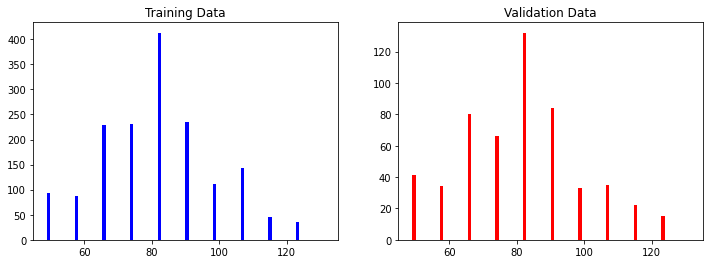

In [44]:
# plot the distributions of train and valid, make sure they are consistent
num_of_bins = 10
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

## [5] 이미지 로딩 및 처리 함수들

### 0> 이미지 로딩을 위한 base directory 설정

In [45]:
data_dir = DATA_DIR
data_dir

'/content/data'

### 1> 이미지 출력하기

In [46]:
def show_image(image):
    plt.figure(figsize=(8,6))
    plt.imshow(image)

def show_compare_images(src_image, tgt_image):
    nrow=1
    ncol=2
    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 6))
    fig.tight_layout()
    axes[0].imshow(src_image)
    axes[1].imshow(tgt_image)

### 2> 이미지 로딩하기

In [47]:
def load_image(data_dir,image_path):
    image_file_path = os.path.join(data_dir,image_path)
    #print("image_file_path->",image_file_path)

    image = cv2.imread(image_file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### 3> 이미지 로딩 및 출력 테스팅

origin_image_file= tub_3_20-07-14/106_cam-image_array_.jpg
origin_steering_angle= 86.0


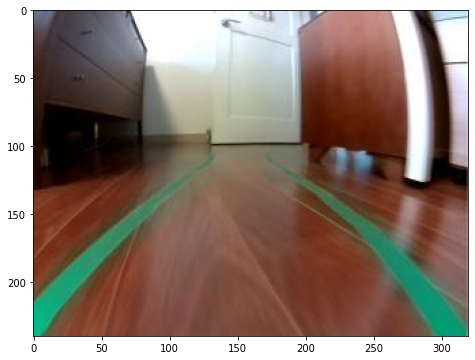

In [52]:
test_sample_index = 10

rgb_image = load_image(data_dir, X_train[test_sample_index])
steering_angle = y_train[test_sample_index]
print("origin_image_file=",X_train[test_sample_index])
print("origin_steering_angle=",steering_angle)
show_image(rgb_image)

In [53]:
rgb_image.shape

(240, 320, 3)

## [6] 이미지 전처리하기(preprocessing)
* NVIDIA모델의 입력 크기로 변경

### 1> 이미지 전처의 단계별 수행과정 이해
* 이미지의 크기 변경 (높이를 1/2로 변경)

In [54]:
# 이미지의 rgb 차원의 slice값으로 이미지 크기를 변경
height, _, _ = rgb_image.shape
resized_rgb_image = rgb_image[int(height/2):,:,:] 

In [55]:
rgb_image.shape

(240, 320, 3)

In [56]:
resized_rgb_image.shape

(120, 320, 3)

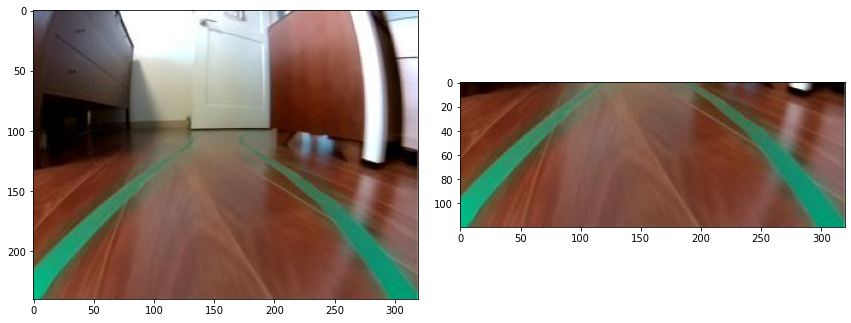

In [57]:
show_compare_images(rgb_image, resized_rgb_image)

### 2> 이미지의 형식변경 (RGB -> YUV)

In [58]:
resized_yuv_image = cv2.cvtColor(resized_rgb_image, cv2.COLOR_RGB2YUV)

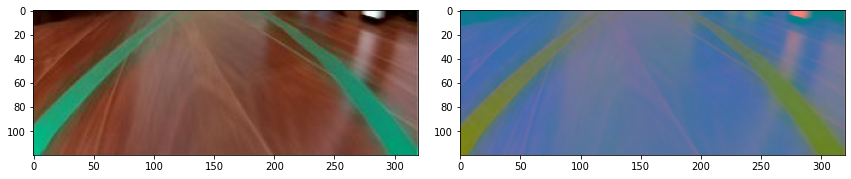

In [59]:
show_compare_images(resized_rgb_image, resized_yuv_image)

### 3> 가우시언블러링 처리(kernel size= 3)

In [60]:
resized_yuv_blurred_image = cv2.GaussianBlur(resized_yuv_image, (3,3), 0)

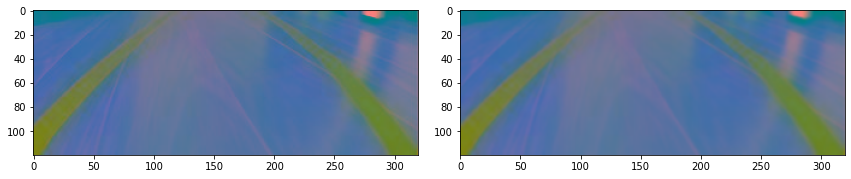

In [61]:
show_compare_images(resized_yuv_image, resized_yuv_blurred_image)

### 4> 이미지 크기 변경 (340x320 -> 66x200)

In [62]:
nvidia_input_image = cv2.resize(resized_yuv_blurred_image, (200,66))

In [63]:
nvidia_input_image.shape

(66, 200, 3)

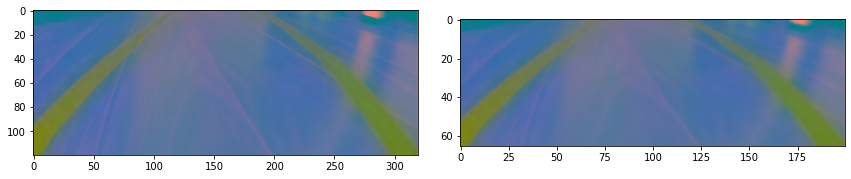

In [64]:
show_compare_images(resized_yuv_image, nvidia_input_image)

### 5> 위의 처리과정의 통합 함수 (img_preprocess)

In [65]:
# 1) 이미지의 포맷을 RGB2YUV로 변경
# 2) GuassianBlur처리를 수행
# 3) 프레임이미지 크기 변경 : 240x320 ->66x200

def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) 
    image = image / 255 
    return image

In [66]:
prep_image = img_preprocess(rgb_image)

In [67]:
prep_image.shape

(66, 200, 3)

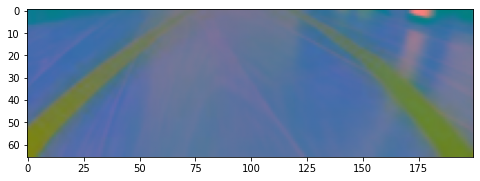

In [68]:
show_image(prep_image)

## [7] NVIDIA 모델 정의하기

### 1> NVIDIA Deep Learning 모델 정의하기

In [69]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

### 2> 모델생성하기 

In [70]:
model = nvidia_model()
print(model.summary())
# check at we will have 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

## [8] NVIDIA 주행 모델 학습하기 

### 1> Tensorboard 설정하기

In [71]:
model_output_dir = '/content/logs'
! mkdir '/content/logs'

In [72]:
# tensorflow의 수행 로그 저장 디렉토리 설정하기
log_dir_root = f'{model_output_dir}/'
log_dir_root

'/content/logs/'

### 2> 학습 및 테스트 데이타 만들기 (이미지 파일 병합하기)

In [73]:
#
# 학습/테스트 이미지 파일명의 리스트를 입력 받아서 numpy.array()로 변환
#

def merge_images(data_dir,filepath_list):
    merge_list = []
    for fname in filepath_list:
        # 원래 이미지를 로딩
        trgb_image = load_image(data_dir,fname)

        # 전처리를 수행
        prep_trgb_image = img_preprocess(trgb_image)
        merge_list.append(prep_trgb_image)
    return np.array(merge_list)

In [74]:
tX_train = merge_images(data_dir,X_train)
tX_train.shape

(1623, 66, 200, 3)

In [75]:
tX_valid = merge_images(data_dir,X_valid)
tX_valid.shape

(542, 66, 200, 3)

### 3> NVIDIA주행 학습하기

* Keara모델 기반의 CNN학습과 동일하게 진행

In [89]:
batch_size = 8
epochs = 35

In [90]:
history = model.fit(tX_train,y_train,
                    batch_size = batch_size,
                    epochs=epochs,
                    validation_data=(tX_valid, y_valid),
                    verbose=1)

Train on 1623 samples, validate on 542 samples
Epoch 1/35
1623/1623 [==============================] - 2s 1ms/step - loss: 25.9473 - val_loss: 16.3503
Epoch 2/35
1623/1623 [==============================] - 2s 1ms/step - loss: 28.9480 - val_loss: 25.5491
Epoch 3/35
1623/1623 [==============================] - 2s 1ms/step - loss: 26.0960 - val_loss: 14.6981
Epoch 4/35
1623/1623 [==============================] - 2s 1ms/step - loss: 20.4822 - val_loss: 15.1433
Epoch 5/35
1623/1623 [==============================] - 2s 1ms/step - loss: 18.3861 - val_loss: 14.4511
Epoch 6/35
1623/1623 [==============================] - 2s 1ms/step - loss: 19.9834 - val_loss: 15.4810
Epoch 7/35
1623/1623 [==============================] - 2s 1ms/step - loss: 17.6513 - val_loss: 12.1426
Epoch 8/35
1623/1623 [==============================] - 2s 1ms/step - loss: 16.1265 - val_loss: 19.5841
Epoch 9/35
1623/1623 [==============================] - 2s 1ms/step - loss: 17.2699 - val_loss: 11.9354
Epoch 10/35
1623/

### 3> 학습모델 저장하기

In [91]:
# epoch를 반복하면서 저장된 모델값은 _check.h5로 저장 
# 최종적인 학습모델의 값을 저장 

trained_model_file = 'nvidia_lane_navigation_final.h5'
model.save(os.path.join(model_output_dir,trained_model_file))

In [92]:
print("model_output_dir=",model_output_dir)

model_output_dir= /content/logs


## [10] 검증하기(validation)

### 1> 학습 및 검증오류 확인하기(그래프)

In [93]:
#history.history

In [94]:
# 학습데이타의 손실/epoch
#history.history['loss']

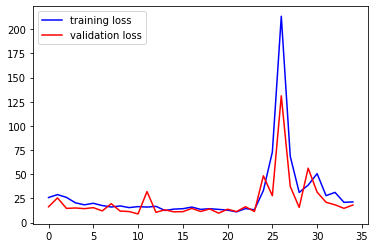

In [95]:
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

### 2> 학습모델 로딩 및 검증결과 출력하기

In [96]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model_file_name = f'{model_output_dir}/{trained_model_file}'
    model = load_model(model_file_name)
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

### 3> 검증결과 출력하기

In [97]:
y_pred = predict_and_summarize(tX_valid, y_valid)

mse       = 1.8e+01
r_squared = 94.09%



### 4> 검증결과 이미지출력하기 

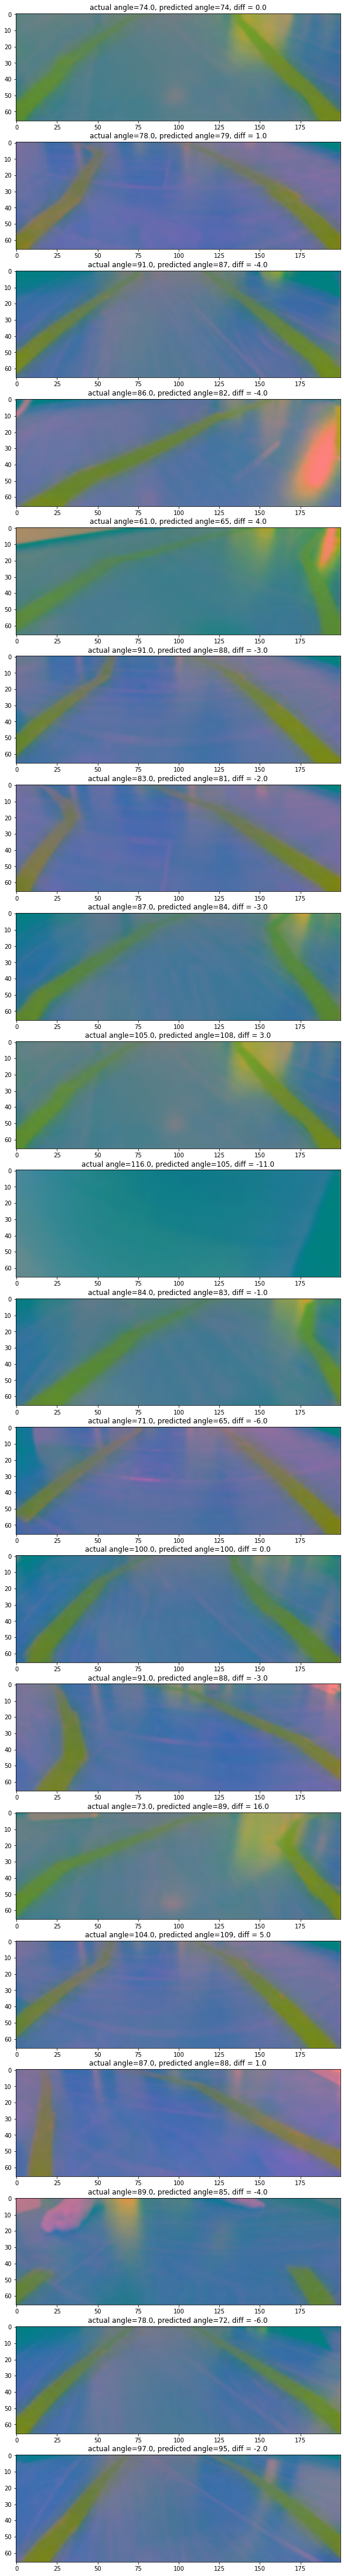

In [98]:
n_tests_show = 20
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(tX_valid[i+5])
    pred_angle = int(y_pred[i])
    axes[i].set_title(f"actual angle={y_valid[i]}, predicted angle={pred_angle}, diff = {pred_angle-y_valid[i]}")

In [99]:
for i in range(n_tests_show):
    pred_angle = int(y_pred[i])
    yv = (y_valid[i]-90)*(1/40)
    yp = (y_pred[i]-90)*(1/40)
    print(f"actual angle={y_valid[i]}, predicted angle={y_pred[i]} => actual={yv}, pred={yp}, diff={yp-yv}")

actual angle=74.0, predicted angle=[74.5547] => actual=-0.4, pred=[-0.3861], diff=[0.0139]
actual angle=78.0, predicted angle=[79.5563] => actual=-0.30000000000000004, pred=[-0.2611], diff=[0.0389]
actual angle=91.0, predicted angle=[87.9819] => actual=0.025, pred=[-0.0505], diff=[-0.0755]
actual angle=86.0, predicted angle=[82.5269] => actual=-0.1, pred=[-0.1868], diff=[-0.0868]
actual angle=61.0, predicted angle=[65.8987] => actual=-0.7250000000000001, pred=[-0.6025], diff=[0.1225]
actual angle=91.0, predicted angle=[88.0201] => actual=0.025, pred=[-0.0495], diff=[-0.0745]
actual angle=83.0, predicted angle=[81.1327] => actual=-0.17500000000000002, pred=[-0.2217], diff=[-0.0467]
actual angle=87.0, predicted angle=[84.6565] => actual=-0.07500000000000001, pred=[-0.1336], diff=[-0.0586]
actual angle=105.0, predicted angle=[108.4910] => actual=0.375, pred=[0.4623], diff=[0.0873]
actual angle=116.0, predicted angle=[105.5836] => actual=0.65, pred=[0.3896], diff=[-0.2604]
actual angle=84.

## [11] 학습모델 로딩 및 파라미터 확인하기


In [100]:
from tensorflow import keras

model_path = os.path.join(model_output_dir,trained_model_file)
print(model_path)

/content/logs/nvidia_lane_navigation_final.h5


In [101]:
# keras model 로딩하기
loaded_model = keras.models.load_model(model_path)

In [102]:
to_json = loaded_model.to_json()
print(to_json)

{"class_name": "Sequential", "config": {"name": "Nvidia_Model", "layers": [{"class_name": "Conv2D", "config": {"name": "conv2d_1", "trainable": true, "batch_input_shape": [null, 66, 200, 3], "dtype": "float32", "filters": 24, "kernel_size": [5, 5], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "elu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Conv2D", "config": {"name": "conv2d_2", "trainable": true, "dtype": "float32", "filters": 36, "kernel_size": [5, 5], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "elu", "use_bias": true, "kernel_

In [103]:
import pprint
import json

In [104]:
pp = pprint.PrettyPrinter()
pp.pprint(json.loads(to_json))

{'backend': 'tensorflow',
 'class_name': 'Sequential',
 'config': {'build_input_shape': [None, 66, 200, 3],
            'layers': [{'class_name': 'Conv2D',
                        'config': {'activation': 'elu',
                                   'activity_regularizer': None,
                                   'batch_input_shape': [None, 66, 200, 3],
                                   'bias_constraint': None,
                                   'bias_initializer': {'class_name': 'Zeros',
                                                        'config': {}},
                                   'bias_regularizer': None,
                                   'data_format': 'channels_last',
                                   'dilation_rate': [1, 1],
                                   'dtype': 'float32',
                                   'filters': 24,
                                   'kernel_constraint': None,
                                   'kernel_initializer': {'class_name': 'VarianceS

## [12] 학습모델 다운로드 받기

학습된 모델이 저장된 폴더인 /content/logs 로 이동합니다. 해당 폴더 아래에 위치한 확장자 h5를 가진 파일을 PC/노트북에 다운로드 하세요. 이 모델을 라즈베리파이에 업로드해서 EMPV1의 자율주행을 실행합니다.

![학습된 주행모델 폴더](https://api.monosnap.com/file/download?id=U8bqUao95gRZ66flfeK4cos8eB1fxy)

## [13] 파즈베리파이에서 학습된 주행모델로 자동주행하기

라즈베리파이의 EMPV1 프로젝트 폴더 아래에 models 디렉토리에 학습한 주행모델을 업로드하고, 아래와 같이 주행을 위한 실행 코드를 실행하여 자율 주행을 시작합니다.

![EMPV1에서 자율주행모델 실행하기](https://api.monosnap.com/file/download?id=2c7u5EJvD13R1TEjkUvpCzUu2YmiNn)